#  Reccomendations: IBM Watson Studio 
---

PROJECT DESCRIPTION

## Table of Contents

In [70]:
#Import required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

import project_tests.project_tests as t

%matplotlib inline

In [2]:
# Import data
user_item_df = pd.read_csv('data/user-item-interactions.csv').drop(columns=['Unnamed: 0'])
content_df = pd.read_csv('data/articles_community.csv').drop(columns=['Unnamed: 0'])

## 1. Exploratory Data Analysis

DATA ANALYSIS DESCRTIPTION

In [3]:
content_df.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


In [4]:
user_item_df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [5]:
# Remove nulls from the data 
user_item_df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

In [6]:
# Drop nulls as we cannot identify the relevent customer email
user_item_dna_df = user_item_df.dropna() 

In [7]:
# Dont need to drop 
content_df.isnull().sum()

doc_body           14
doc_description     3
doc_full_name       0
doc_status          0
article_id          0
dtype: int64

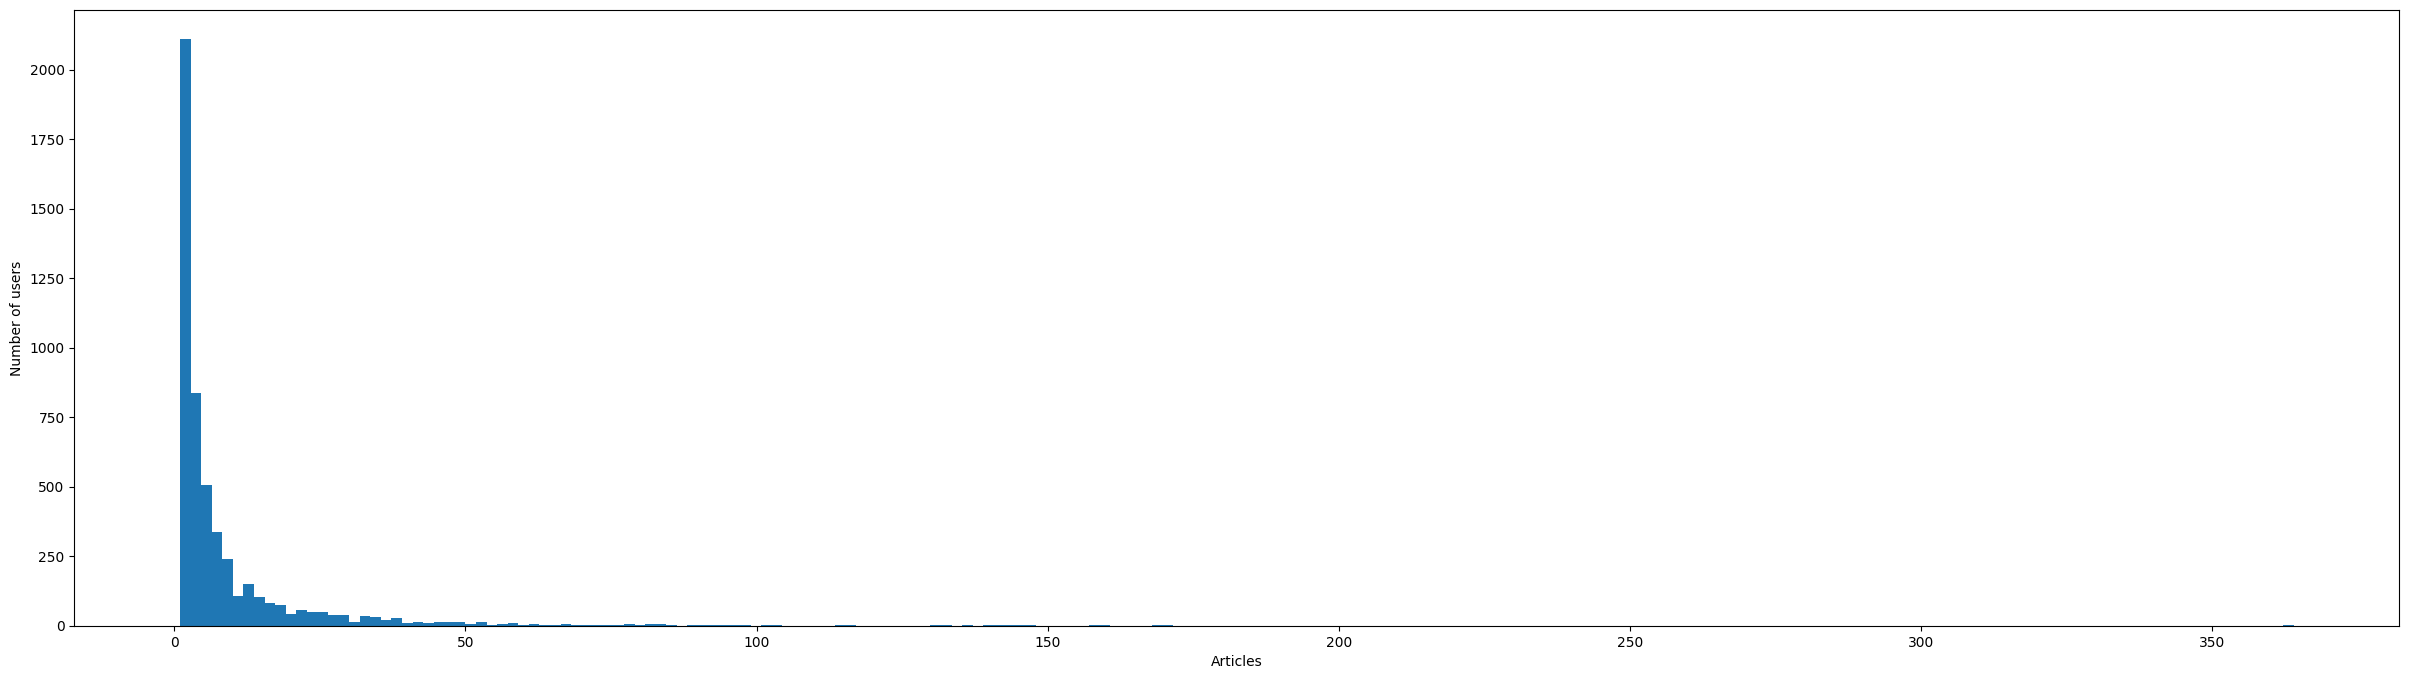

In [8]:
#Understand the distribution of articles read 
user_interactions_total_df = user_item_df.groupby('email').count()['article_id'].reset_index()

plt.figure(figsize=(30,8))
plt.hist(user_interactions_total_df['article_id'], bins=200);
plt.xlabel('Articles')
plt.ylabel('Number of users')
plt.show()

In [9]:
# Get the median valu for user to get the bottom 50% of interactions 
median_interactions = int(user_interactions_total_df['article_id'].median())

# Maximum user interaction 
maximum_articles_interaction = int(user_interactions_total_df['article_id'].max())

total_interactions = int(user_item_df.count()['article_id'])

# Most viewed article amount 

In [10]:
most_viewed = user_item_df.groupby('article_id').count().reset_index().sort_values('email',ascending= False)[0:1]

In [11]:
unique_articles = len(user_item_df['article_id'].unique())
unique_users = len(user_item_dna_df['email'].unique())## null value being taken out 
unique_articles_platform = len(content_df['article_id'].unique())

In [12]:
type(unique_articles)

int

In [13]:
sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_interactions,
    '`The total number of user-article interactions in the dataset is ______.`': total_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': maximum_articles_interaction,
    '`The most viewed article in the dataset was viewed _____ times.`': most_viewed['email'].item(),
    '`The article_id of the most viewed article is ______.`': str(most_viewed['article_id'].item()),
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': unique_articles_platform,
}

t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


## 2. Rank-Based Recommendations

Rank based on number of times article is visitied by the same user as we don't have any other rating systems we can use

In [14]:
user_item_df[['article_id','email']]\
    .groupby(['email']).count()\
    .sort_values('article_id',ascending=False)\
    .reset_index()[:5]

,email,article_id
0,2b6c0f514c2f2b04ad3c4583407dccd0810469ee,364
1,77959baaa9895a7e2bdc9297f8b27c1b6f2cb52a,363
2,2f5c7feae533ce046f2cb16fb3a29fe00528ed66,170
3,a37adec71b667b297ed2440a9ff7dad427c7ac85,169
4,8510a5010a5d4c89f5b07baac6de80cd12cfaf93,160


In [15]:
# Create function to get the top n articles 
def top_n_articles(n:int):
    '''
    Input
    n: number of top articles to return

    Output
    Returns a sorted list of the most viewed articles up to n amount 

    '''

    df = user_item_df

    top_df = df[['title','email']]\
                .groupby(['title']).count()\
                .sort_values('email',ascending=False)\
                .reset_index()[:n]

    top_articles = top_df['title'].to_list()

    

    return top_articles

In [16]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = top_n_articles(5)
top_10 = top_n_articles(10)
top_20 = top_n_articles(20)

In [17]:
t.sol_2_test(top_n_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your to_20 looks like the solution list! Nice job.


## 3. User-User Based Collaborative Filtering

In [18]:
# add in customer id as email is very long 
unique_email_id = pd.DataFrame(user_item_df['email'].unique(),columns = ['email'])\
    .sort_values('email')\
    .reset_index(names = ['user_id'])

In [19]:
def email_mapper(df):
    '''
    Map the user email to a user_id column and remove the email column
    '''

    coded_dict = dict()
    cter = 1
    email_encoded = []

    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter += 1

        email_encoded.append(coded_dict[val])

    return email_encoded

email_encoded = email_mapper(user_item_df)
user_item_df['user_id'] = email_encoded

In [20]:
# May not work so ignore 

def user_item_matrix(df):
    '''
    Input
    df: data frame or articles each user has interacted with at a user id level

    Output:
    A matrix of user id's and a binary flag for if they have interacted with an article
    '''

    user_item_matrix = pd.merge(df,unique_email_id,how = 'inner', on = 'email')\
                                .groupby(['user_id', 'article_id'])['title']\
                                .agg(lambda x: 1).unstack()

    user_item_matrix.fillna(0,inplace = True)

    return user_item_matrix

In [21]:
# Create matrix of binary 1's and 0's for articles customers have read 

def user_item_matrix(df):
    '''
    Input
    df: data frame or articles each user has interacted with at a user id level

    Output:
    A matrix of user id's and a binary flag for if they have interacted with an article
    '''

    user_item_matrix = user_item_df\
                        .groupby(['user_id', 'article_id'])['title']\
                        .agg(lambda x: 1).unstack()
    
    user_item_matrix.fillna(0,inplace = True)

    return user_item_matrix

user_item_matrix = user_item_matrix(user_item_df)

In [22]:
# Tests
assert user_item_matrix.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item_matrix.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item_matrix.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."

print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [29]:
np.array(user_item_matrix.loc[10]).reshape(-1,1)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [ ]:
# First step of reccomendation is to find user similarity 
def find_similar_users(user_id, user_item_matrix = user_item_matrix):
    """
    Input
    user_id: The user we want to find the most similar users too
    user_item_matrix: Matrix of users and the articles they have veiwed 
    """

    # Use a sparse matrix to speep up comutation time 
    user_item_sparse = csr_matrix(user_item_matrix.values)

    user_index = user_item_matrix.index.get_loc(user_id)
    user_vector = user_item_sparse[user_index, :]
    matrix_no_user_id = user_item_sparse[np.arange(user_item_sparse.shape[0]) != user_index, :]
    similarity = matrix_no_user_id.dot(user_vector.T).toarray().flatten()

    similarity_df = pd.DataFrame({'user_id': user_item_matrix.index[np.arange(user_item_matrix.shape[0]) != user_index],
                                  'similarity': similarity}).sort_values('similarity', ascending=False)

    return list(similarity_df['user_id'])

In [78]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(
    find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(
    find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(
    find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 3782, 23, 4459, 203, 131, 3870, 46, 4201, 5041]
The 5 most similar users to user 3933 are: [1, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


In [90]:
# Find the names of articles 
def get_article_names(article_ids,user_item_df=user_item_df):
    """
    Input:
    article_ids: a list or single value of article id's 
    user_item_df: User item data frame of articles users have veiwed 

    Output:
    List of distinct article name from the corresponding article id's 

    """

    if type(article_ids) == list:
        True
    else:
        article_ids = [article_ids]

    article_names = list(user_item_df[user_item_df['article_id'].isin(article_ids)]['title']\
                                .unique())
    
    return article_names

In [95]:
def get_user_articles(user_id, user_item_df=user_item_df):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles:
                1's when a user has interacted with an article, 0 otherwise

    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with
                    the list of article ids

    Description:
    Provides a list of the article_ids and article titles that have
    been seen by a user
    '''
    user_articles_df = user_item_df[user_item_df['user_id'] == user_id]
    article_ids = list(user_articles_df['article_id'].unique())
    article_ids = [int(article_id) for article_id in article_ids]
    article_names = get_article_names(article_ids)
    return article_ids, article_names